# Demo 3b: Classical uncertainty
## Introduction
In this iPython notebook, we'll play around with the notion of probability and uncertainty in the setting of a classical particle in a box. 

![](files/Boxed_particle.gif)

We'll **review** some of the stuff you learned in PSET_1 such as: 

1.  A for loop within a for loop!
2.  Plotting a histogram.
3.  Calculating the mean of an array of numbers.

And we'll play around with some **new concepts** :


1.  Verlet integrator function.
2.  Phase space plots.
3.  Sampling from a probability distribution function.
4.  Plotting a scatter plot.


# Step 1 : let's import some useful modules

In [1]:
%matplotlib inline  
import numpy as np #python numerical library
from scipy import integrate #a function to integrate
import matplotlib.pyplot as plt #plotting library

# Step 2: Define some functions that we'll use further below.
### Browse them and get a sense of what they're doing the inputs and outputs are!!


## Velocity verlet algorithm
Which updates positions and velocities given an acceleration function $a(x)$ as:

$$
x_{n+1} =x_{n} + v_n dt + \frac{a(x_n)dt^2}{2}
$$
$$
v_{n+1} =v_{n} + \frac{a(x_n) + a(x_{n+1})}{2 dt}
$$


In [2]:
def verlet(x, v, dt, a):
    '''
    This is a simple implementation of the velocity verlet algorithm.
    INPUT
    x: scalar or vector of current positions
    v: scalar or vector of current velocities
    dt: scalar double of the current time step
    a: a function pointer to the acceleration function
    
    OUTPUT:
    xnew: scalar or vector of the updated positions. The data type (scalar or vector) will be the 
          same as what is passed in to x, as the type will be infered.
    vnew: scalar of vector of the updated velocities. The data type (scalar or vector) will be the 
          same as what is passed in to v, as the type will be infered.
    '''
    xnew = x + v*dt + a(x)*dt**2/2
    vnew = v + (a(x) + a(xnew))/2*dt
    return xnew, vnew

## Our acceleration function
In this case, where the classical particle in a box does not undergo acceleration, the $a(x)$ function is embarrasingly trivial:

$$
a(x)=0
$$

In [3]:
def a_box(x):
    '''
    This defines the acceleration of a particle in a box, which is zero. If you think this is silly, well it is. 
    But this is the last time we'll use such a simple acceleration function :)
    INPUT:
    x: scalar, not used at all
    OUTPUT:
    a: a scalar that returns the acceleration due to gravity
    '''
    a=0
    return a

## Trajectory Integrator
This function is where we get the full trajectory of the particle from **startTime** to **stopTime**, with time step **dt**, by iteratively calling the verlet integrator function. At the heart of the function is a for loop (can you see it???)  

The important input values here will be the initial position and velocity, x0, v0

### <i class="fa fa-exclamation-circle"></i> (find and understand the portion of the code that specifies the boundary conditions, i.e. where we tell the particle to bounce off the walls.)

In [4]:
def ode_integrate_box(x0, v0, a, startTime = 0.0, stopTime = 7.0, dt = 0.01, mass = 1.0):
    '''
    This is the method that we created to stop the copying and pasting that we were doing to solve
    ODEs.
    INPUT
    x0 = scalar or vector of initial positions
    v0 = scalar or vector of initial velocities
    a = function pointer to the acceleration function. Note that this can only be position dependent
    startTime = optional argument, keyworded. Scalar that defines the starting point of the time array
    stopTime = optional argument, keyworded. Scalar that defines the ending point of the time array
    dt = optional argument, keyworded. Scalar that defines the time step of the time array
    mass = optional argument, keyworded. Scalar that defines the mass of the object
    OUTPUT
    t = vector of times
    xlist = vector of positions from the propagation
    vlist = vector of velocities from the propagation
    '''
    t = np.arange(startTime, stopTime, dt)

    # This creates a zeroed out array that's the shape of the time array. This is important for a few reasons
    # 1) We already know that we want to have collected a position and velocity at each time, t
    # 2) By creating all of our arrays at once, we avoid any troubles with memory that could complicate issues.
    xlist = np.zeros_like(t) 
    vlist = np.zeros_like(t)

    # Here, we apply our initial conditions
    xlist[0] = x0 
    vlist[0] = v0    
    
    # We've set up a for loop that loops over the entire time array that we've defined above.
    # What this is saying is that it will perform the inside of the loop for each of the values of i
    # and i will range from 1 to the length of t, the time array
    for i in range(1, len(t)):
        xlist[i], vlist[i] = verlet(xlist[i-1],
                                    vlist[i-1],
                                    dt,
                                    a_box) 
        ####THIS IS WHERE THE PARTICLE BOUNCES OFF THE WALLS####
        if xlist[i] <= 0.0: # If statement to check whether the object has hit the walls of the box
            xlist[i] = 0.0
            vlist[i] = -vlist[i] #the velocity changes directions
        elif xlist[i] >= L:
            xlist[i] = L
            vlist[i] = -vlist[i] #the velocity changes direction

    return t, xlist, mass*vlist  #what does the funtion return?  the time array, the list of positions, and of momenta

# Step 3: Initial Conditions

## Let's define some parameter values and initialize our variables

Among the parameter values that we'll define, are the **mean and variance of the normal/Gaussian distributions** that we'll use to sample initial positions and velocities of our particle. 

Recall that the probability density function (pdf) for the normal distribution is given by <br>
$$P(x) = \frac{1}{{\sigma \sqrt {2\pi } }}e^{ -  \frac{(x - x_o )^2}{ 2\sigma^2 } } $$

First we'll define the **parameters $x_o$ and $\sigma$, the mean and the variance**, for the normal/Gaussian distributions we'll use to draw values of the initial velocity and position, v0, and x0




### <i class="fa fa-flask"></i> Experiment with different values

* First, run the code below with a very small value of sigma_velocity and sigma_position, to simulate a delta function (e.g. 0.001).

* Second, run it again with a larger value of sigma_velocity and sigma_position (e.g. 0.2 - 0.5)

In [5]:
L=10 # this is then length of the box. 

#This defines the parameters of the normal distribution
# that we'll use to draw random positions and velocities

##################
###You should play around with different values!!!
mu_velocity = 5.0  # mean
sigma_velocity = 0.2  # variance

mu_position = L/2.0  # mean
sigma_position = 0.2  # variance

and some other parameters and empty variable lists (i.e. the empty lists where we'll store our initial and final positions and momenta)

In [6]:
stopT = 10 #this is the final time of each trajectory,

#num_iter is the number of different times that we'll repeat the trajectory simulation
# each time with different initial velocities and positions
num_iter = 500

p0_list = [] #an empty list with initial momenta
x0_list = []  # and positions

pf_list = [] #an empty list with final momenta
xf_list = [] # and positions

# Step 4: Now to the action!
Let's run many (**num_iter**) trajectories of the classical particle in a box.
But with random initial positions and velocities drawn from normal/gaussian distributions

In [7]:
#We'll plot all the phase space trajectories in the same figure, so let's set up our figure
x_list_full = []
p_list_full = []
for iter in range(num_iter): # a for loop that runs the trajectories for many iterations

    ###########################
    #### This is where we define the random initial position
    ### Write two lines of code: 
    ###The first, assigns to x0 a random number drawn 
    ### from a normal gaussian distribution with parameters mu_position, sigma_position
    ### The second, assigns to v0 a random number drawn
    ### from a normal gaussian distribution with parameters mu_position, sigma_position
    ###HINT use the numpy.random library, and google is your friend.    
    
    #########################

    x0 = np.random.normal(mu_position,sigma_position)
    v0 = np.random.normal(mu_velocity,sigma_velocity)
    
    #we call the ode_integrate_box function to give us our trajectory!
    time, xlist, plist = ode_integrate_box(x0, v0, a_box, stopTime = stopT)

    x0_list.append(x0) #store a list of all the initial positions and momenta
    p0_list.append(v0)
    
    xf_list.append(xlist[-1]) #store a list of all the final positions and momenta.   
    pf_list.append(plist[-1]) #the [-1] index returns the last item in a list. 
    x_list_full.append(xlist)
    p_list_full.append(plist)

## Let plot time vs position for the last particle

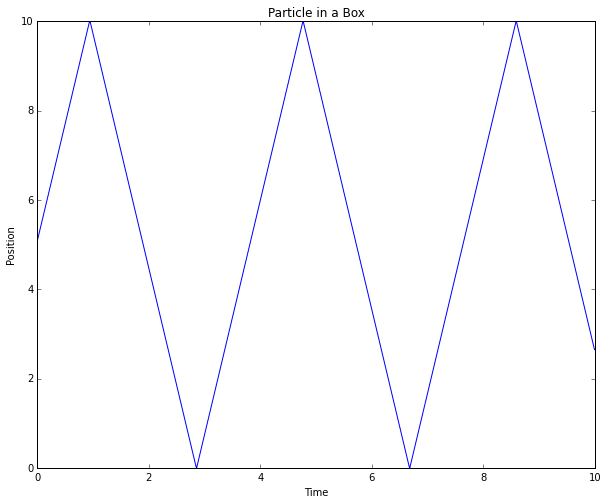

In [8]:
plt.figure(figsize=(10,8))
plt.plot(time,xlist)
plt.title('Particle in a Box')
plt.xlabel('Time')
plt.ylabel('Position')
plt.show()

## Let plot time vs momentum for the last particle

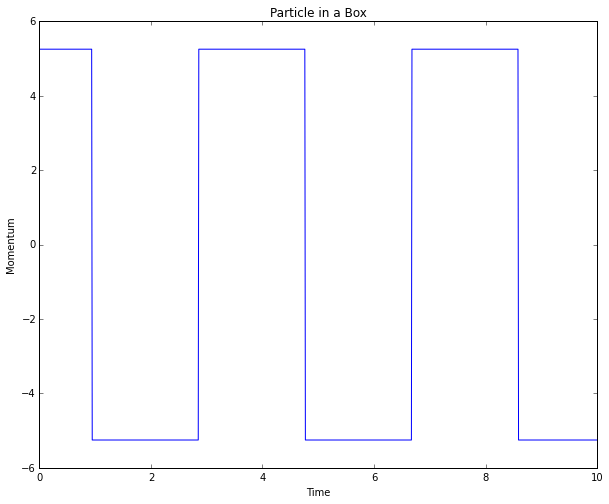

In [9]:
plt.figure(figsize=(10,8))
plt.plot(time,plist)
plt.title('Particle in a Box')
plt.xlabel('Time')
plt.ylabel('Momentum')
plt.show()

## Now the phase plot of all particles!
### We will be plotting all dynamical variables (Position & Momentum)

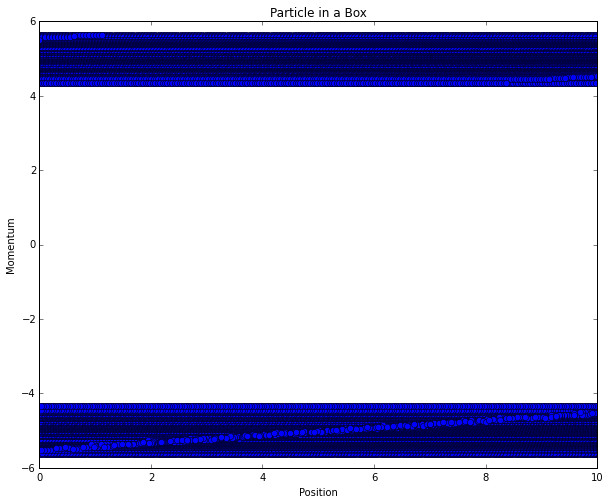

In [10]:
plt.figure(figsize=(10,8))
plt.plot(x_list_full,p_list_full,'bo')
plt.title('Particle in a Box')
plt.xlabel('Position')
plt.ylabel('Momentum')
plt.show()

### <i class="fa fa-question-circle"></i> What do horizontal straight lines mean in this plot?
### <i class="fa fa-question-circle"></i> Would this change with a different $a(x)$?

# Step 5: Visualize distributions of particles
## Initial velocities

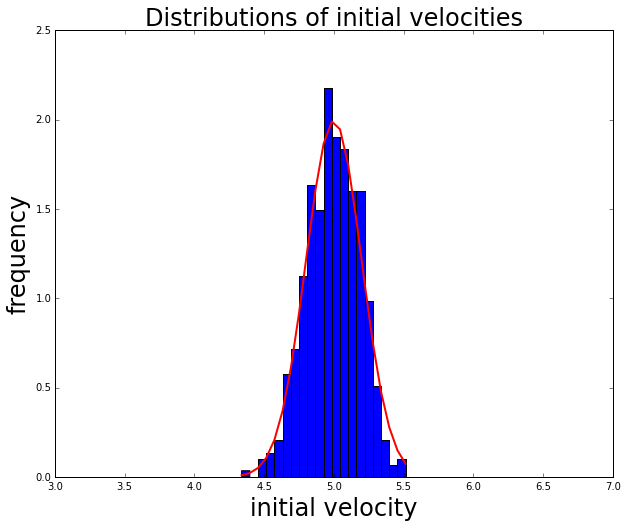

In [21]:
#Create a figure: 
plt.figure(figsize=(10,8))

#Call the matplotlib.pyplot function that plots a histogram.  Google it up!
count, bins, ignored = plt.hist(p0_list, 20, normed = True)

#We'll overlay the analytical expression for the normal distribution too.  The x values are the bins. 
normal_dist = 1/(sigma_velocity * np.sqrt(2 * np.pi))*np.exp( - (bins - mu_velocity)**2 / (2 * sigma_velocity**2) )

#Let's plot!
plt.plot(bins, normal_dist, linewidth=2, color='r')
plt.xlabel('initial velocity', fontsize=24)
plt.ylabel('frequency', fontsize=24)
plt.xlim((mu_velocity - 2, mu_velocity + 2))
plt.title('Distributions of initial velocities', fontsize=24)
plt.show()

## Initial positions

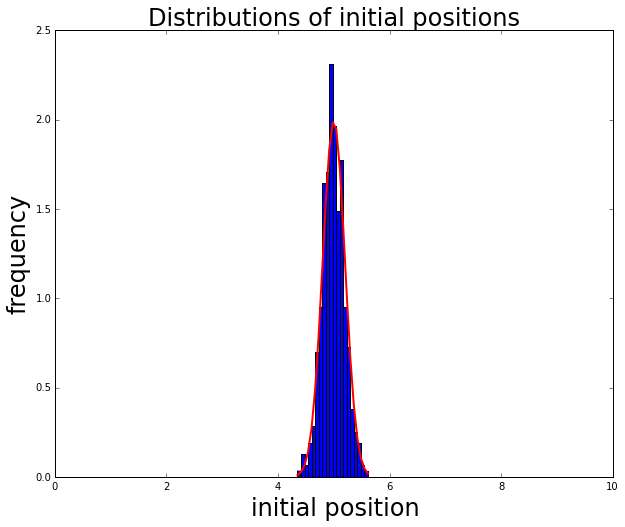

In [22]:
#Create a figure: 
plt.figure(figsize=(10,8))

#Call the matplotlib.pyplot function that plots a histogram.  Google it up!
count, bins, ignored = plt.hist(x0_list, 20, normed = True)

#We'll overlay the analytical expression for the normal distribution too.  The x values are the bins. 
normal_dist = 1/(sigma_position * np.sqrt(2 * np.pi))*np.exp( - (bins - mu_position)**2 / (2 * sigma_position**2) )

#Let's plot!
plt.plot(bins, normal_dist, linewidth=2, color='r')
plt.xlabel('initial position', fontsize=24)
plt.ylabel('frequency', fontsize=24)
plt.xlim((0,L))
plt.title('Distributions of initial positions', fontsize=24)
plt.show()

## Phase plot

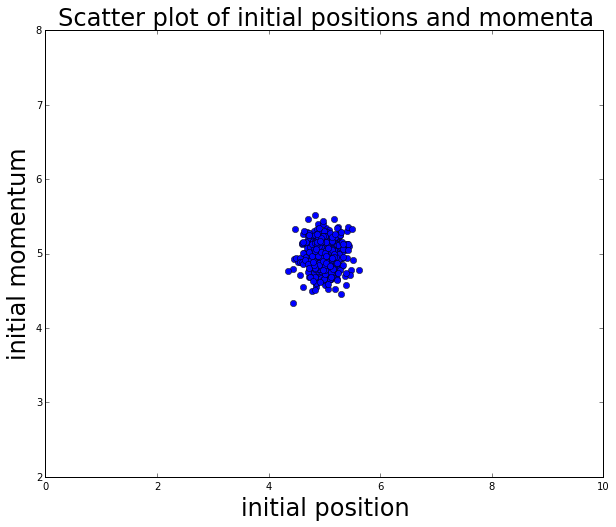

In [23]:
#Create a figure: 
plt.figure(figsize=(10,8))
v=plt.plot(x0_list, p0_list, 'o')
plt.xlabel('initial position', fontsize=24)
plt.ylabel('initial momentum', fontsize=24)
plt.title('Scatter plot of initial positions and momenta', fontsize=24)
plt.xlim((0,L))
plt.ylim((2,8))
plt.show()

# What about the final velocities and positions? 

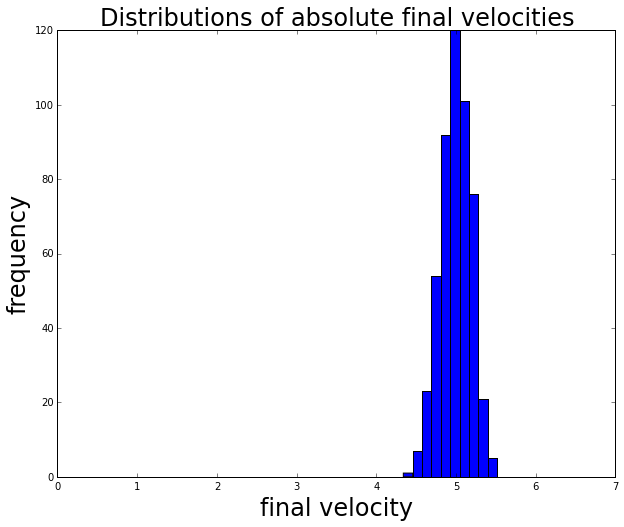

In [30]:
#Create a figure: 
plt.figure(figsize=(10,8))
plt.hist(np.abs(pf_list))
plt.xlabel('final velocity', fontsize=24)
plt.ylabel('frequency', fontsize=24)
plt.xlim((0, mu_velocity + 2))
plt.title('Distributions of absolute final velocities', fontsize=24)
plt.show()

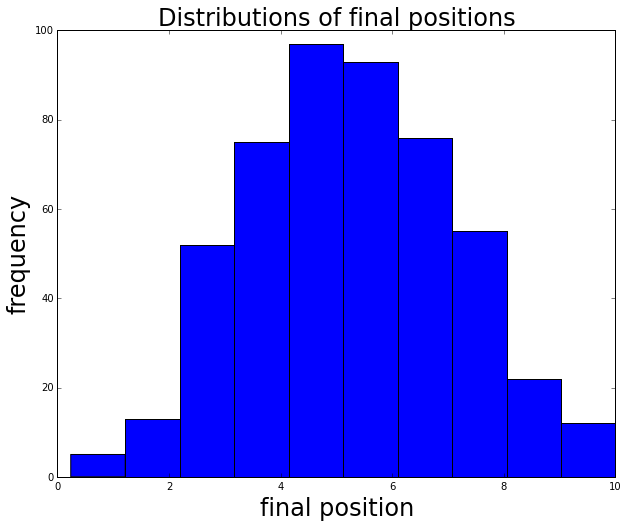

In [25]:
#Create a figure: 
plt.figure(figsize=(10,8))
plt.hist(xf_list, 10)
plt.xlabel('final position', fontsize=24)
plt.ylabel('frequency', fontsize=24)
plt.xlim((0,L))
plt.title('Distributions of final positions', fontsize=24)
plt.show()

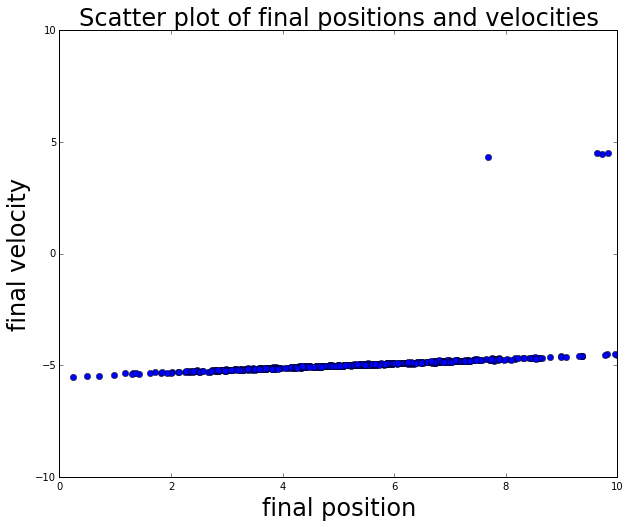

In [16]:
#Create a figure: 
plt.figure(figsize=(10,8))
plt.plot(xf_list, pf_list, 'o')
plt.xlabel('final position', fontsize=24)
plt.ylabel('final velocity', fontsize=24)
plt.title('Scatter plot of final positions and velocities', fontsize=24)
plt.xlim((0,L))
plt.ylim((-10,10))
plt.show()

# Step 6: Calculate the expectation value

## Hint: google up a function in numpy that lets you take the expectation/expected value of an array of numbers.

Run it and assign the values to the variables:
* x0_list to x0_mean
* p0_list to p0_mean
* xf_list to xf_mean
* pf_list to pf_mean


In [31]:
# One line of code per variable
x0_mean = np.mean(x0_list)
p0_mean = np.mean(p0_list)
xf_mean = np.mean(xf_list)
pf_mean = np.mean(pf_list)

In [32]:
print("The expected initial position is %f"%x0_mean)
print("The expected initial momentum is %f"%p0_mean)

print("The expected final position is %f"%xf_mean)
print("The expected final momentum is %f"%pf_mean)

The expected initial position is 4.986232
The expected initial momentum is 4.991560
The expected final position is 5.262095
The expected final momentum is -4.920351
